# Realtime VAD

Let say you want to cut your realtime recording audio by using VAD, malaya-speech able to do that.

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/realtime-vad](https://github.com/huseinzol05/malaya-speech/tree/master/example/realtime-vad).
    
</div>

<div class="alert alert-info">

This module is language independent, so it save to use on different languages. Pretrained models trained on multilanguages.
    
</div>

<div class="alert alert-warning">

This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

In [1]:
import malaya_speech
from malaya_speech import Pipeline

### Load VAD model

Fastest and common model people use, is webrtc. Read more about VAD at https://malaya-speech.readthedocs.io/en/latest/load-vad.html

In [2]:
webrtc = malaya_speech.vad.webrtc()

### Recording interface

So, to start recording audio including realtime VAD, we need to use `malaya_speech.streaming.record`. We use `pyaudio` library as the backend.

```python
def record(
    vad,
    asr_model = None,
    device = None,
    input_rate: int = 16000,
    sample_rate: int = 16000,
    blocks_per_second: int = 50,
    padding_ms: int = 300,
    ratio: float = 0.75,
    min_length: float = 0.1,
    filename: str = None,
    spinner: bool = False,
):
    """
    Record an audio using pyaudio library. This record interface required a VAD model.

    Parameters
    ----------
    vad: object
        vad model / pipeline.
    asr_model: object
        ASR model / pipeline, will transcribe each subsamples realtime.
    device: None
        `device` parameter for pyaudio, check available devices from `sounddevice.query_devices()`.
    input_rate: int, optional (default = 16000)
        sample rate from input device, this will auto resampling.
    sample_rate: int, optional (default = 16000)
        output sample rate.
    blocks_per_second: int, optional (default = 50)
        size of frame returned from pyaudio, frame size = sample rate / (blocks_per_second / 2).
        50 is good for WebRTC, 30 or less is good for Malaya Speech VAD.
    padding_ms: int, optional (default = 300)
        size of queue to store frames, size = padding_ms // (1000 * blocks_per_second // sample_rate)
    ratio: float, optional (default = 0.75)
        if 75% of the queue is positive, assumed it is a voice activity.
    min_length: float, optional (default=0.1)
        minimum length (s) to accept a subsample.
    filename: str, optional (default=None)
        if None, will auto generate name based on timestamp.
    spinner: bool, optional (default=False)
        if True, will use spinner object from halo library.


    Returns
    -------
    result : [filename, samples]
    """
```

**Once you start to run the code below, it will straight away recording your voice**. Right now I am using built-in microphone.

If you run in jupyter notebook, press button stop up there to stop recording, if in terminal, press `CTRL + c`.

In [4]:
file, samples = malaya_speech.streaming.record(webrtc)
file

saved audio to savewav_2020-11-26_22-36-06_294832.wav (ctrl-C to stop recording) ...| Listening (ctrl-C to stop recording) .../ Listening (ctrl-C to stop recording) ... Listening (ctrl-C to stop recording) ...\ Listening (ctrl-C to stop recording) ...| Listening (ctrl-C to stop recording) .../ Listening (ctrl-C to stop recording) ...- Listening (ctrl-C to stop recording) ...\ Listening (ctrl-C to stop recording) ...| Listening (ctrl-C to stop recording) .../ Listening (ctrl-C to stop recording) ...- Listening (ctrl-C to stop recording) ...\ Listening (ctrl-C to stop recording) ... Listening (ctrl-C to stop recording) ...\ Listening (ctrl-C to stop recording) ...| Listening (ctrl-C to stop recording) .../ Listening (ctrl-C to stop recording) ...- Listening (ctrl-C to stop recording) ...\ Listening (ctrl-C to stop recording) ...| Listening (ctrl-C to stop recording) .../ Listening (ctrl-C to stop recording) ...- Listening (ctrl-C to stop recording) ...\ Listening (ctrl-C to stop recordin

'savewav_2020-11-26_22-36-06_294832.wav'

get the audio at [malaya-speech/speech/record](https://github.com/huseinzol05/malaya-speech/tree/master/speech/record).

As you can see, it will automatically save to a file, and you can check the length of samples.

In [5]:
len(samples)

4

means, we got 4 subsamples!

In [6]:
import IPython.display as ipd
ipd.Audio(file)

In [7]:
ipd.Audio(malaya_speech.astype.to_ndarray(samples[0][0]), rate = 16000)

In [8]:
ipd.Audio(malaya_speech.astype.to_ndarray(samples[1][0]), rate = 16000)

In [9]:
ipd.Audio(malaya_speech.astype.to_ndarray(samples[2][0]), rate = 16000)

In [10]:
ipd.Audio(malaya_speech.astype.to_ndarray(samples[3][0]), rate = 16000)

### Use pipeline

We know, webrtc does not work really good in noisy environment, so to improve that, we can use VAD deep model from malaya-speech.

In [11]:
vad_model = malaya_speech.vad.deep_model(model = 'vggvox-v2', quantized = True)

**pyaudio will returned int16 bytes, so we need to change to numpy array, normalize it to -1 and +1 floating point**.

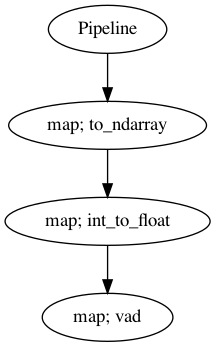

In [13]:
p = Pipeline()
pipeline = (
    p.map(malaya_speech.astype.to_ndarray)
    .map(malaya_speech.astype.int_to_float)
    .map(vad_model)
)
p.visualize()

**Once you start to run the code below, it will straight away recording your voice**. Right now I am using built-in microphone.

If you run in jupyter notebook, press button stop up there to stop recording, if in terminal, press `CTRL + c`.

In [14]:
file, samples = malaya_speech.streaming.record(p)
file

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=320
  n_fft, y.shape[-1]


saved audio to savewav_2020-11-26_22-40-56_929661.wav (ctrl-C to stop recording) ...| Listening (ctrl-C to stop recording) .../ Listening (ctrl-C to stop recording) ...- Listening (ctrl-C to stop recording) ...\ Listening (ctrl-C to stop recording) ... Listening (ctrl-C to stop recording) ...\ Listening (ctrl-C to stop recording) ...| Listening (ctrl-C to stop recording) .../ Listening (ctrl-C to stop recording) ...- Listening (ctrl-C to stop recording) ...\ Listening (ctrl-C to stop recording) ...| Listening (ctrl-C to stop recording) .../ Listening (ctrl-C to stop recording) ...- Listening (ctrl-C to stop recording) ... Listening (ctrl-C to stop recording) ...\ Listening (ctrl-C to stop recording) ...| Listening (ctrl-C to stop recording) .../ Listening (ctrl-C to stop recording) ...- Listening (ctrl-C to stop recording) ...\ Listening (ctrl-C to stop recording) ...| Listening (ctrl-C to stop recording) .../ Listening (ctrl-C to stop recording) ... Listening (ctrl-C to stop recording

'savewav_2020-11-26_22-40-56_929661.wav'

get the audio at [malaya-speech/speech/record](https://github.com/huseinzol05/malaya-speech/tree/master/speech/record).

In [15]:
len(samples)

4

In [16]:
ipd.Audio(file)

In [17]:
ipd.Audio(malaya_speech.astype.to_ndarray(samples[0]), rate = 16000)

In [18]:
ipd.Audio(malaya_speech.astype.to_ndarray(samples[1]), rate = 16000)

In [19]:
ipd.Audio(malaya_speech.astype.to_ndarray(samples[2]), rate = 16000)

In [20]:
ipd.Audio(malaya_speech.astype.to_ndarray(samples[3]), rate = 16000)